In [1]:
import glob
import numpy as np
import pandas as pd
import xarray as xr 
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
from matplotlib import animation, rc

plt.rcParams['text.usetex'] = True
plt.rcParams['animation.html'] = 'jshtml'

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def make_colorbar(mf_dataset):
    #---------------------------------------------------------------------------
    # For Seting up the colorbar:
    #    - http://csc.ucdavis.edu/~jmahoney/matplotlib-tips.html
    #---------------------------------------------------------------------------
    cmap = cm.plasma
    norm = mcolors.Normalize(vmin=np.min(mf_dataset.Delta_MB),
                                  vmax=np.max(mf_dataset.Delta_MB))

    s_map = cm.ScalarMappable(norm=norm, cmap=cmap)
    s_map.set_array(mf_dataset.Delta_MB)

    # If color parameters is a linspace, we can set boundaries in this way
    halfdist = (mf_dataset.Delta_MB[1] - mf_dataset.Delta_MB[0]) / 2.0
    bounds   = np.linspace(mf_dataset.Delta_MB[0]   - halfdist,
                           mf_dataset.Delta_MB[-1]  + halfdist,
                           len(mf_dataset.Delta_MB) + 1)

    return cmap, norm, s_map, bounds

# Plot Synthetic Geometry 

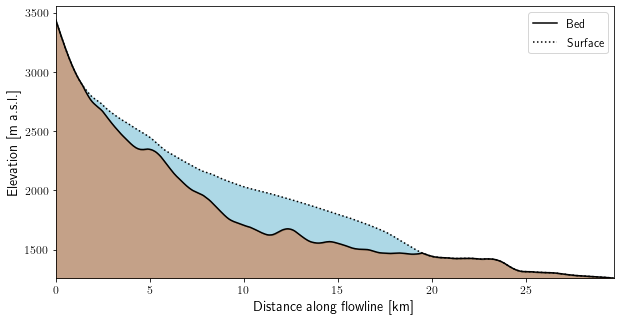

In [2]:
bed  = np.loadtxt('../../input_data/lilk-a_bed.dat')
surf = np.loadtxt('../../input_data/lilk-a_surf.dat')


fig, ax = plt.subplots(1,1,figsize=(10, 5))

ax.plot( bed[::-1,0] / 1e3,  bed[:,1], 'k' , label='Bed')
ax.plot(surf[::-1,0] / 1e3, surf[:,1], 'k:', label='Surface')
ax.legend()

ax.fill_between(bed[::-1,0] / 1e3, bed[:,1], surf[:,1], color='lightblue')
ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
                bed[:,1], color='saddlebrown', alpha=0.5)

ax.set_xlim(0, bed[:,0].max() / 1e3)
ax.set_ylim(bed[:,1].min(), None)

ax.set_ylabel('Elevation [m a.s.l.]')
ax.set_xlabel('Distance along flowline [km]')

fig.savefig('./figs/synth_geom.png', dpi=300,
            bbox_inches='tight', facecolor='w')

# Mass Balance Gridsearch

In [3]:
sources = []

for fp in sorted(glob.glob("./nc/relax_*.nc")):
    with xr.open_dataset(fp) as src: 
        src["Z"]     = src.zbed + src.Z * src.height 
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
        sources.append(src)
    
mf_dataset = xr.concat(sources,
                       pd.Index(data = np.linspace(2000, 2500, 11),
                                name = 'Delta_MB'))

Vol = mf_dataset.isel(coord_2=-1).height.integrate('coord_1') / \
      mf_dataset.isel(coord_2=-1, t=0).height.integrate('coord_1')

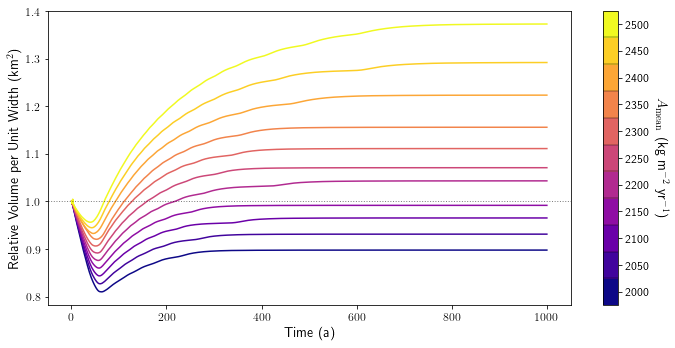

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))

# Make a colormap and all the associated var names
cmap, norm, s_map, bounds = make_colorbar(mf_dataset)
    
for delta_mb in Vol.Delta_MB:
    color = cmap(norm(delta_mb))
    ax.plot(Vol.t, Vol.sel(Delta_MB=delta_mb), color=color)

ax.axhline(1.0,c='k',ls=':',lw=1, alpha=0.5)

cbar = fig.colorbar(s_map,
                spacing='proportional',
                ticks=mf_dataset.Delta_MB,
                ax=ax,
                boundaries=bounds,
                drawedges=True,
                format='%2.0f')

# annotate the figures axes
ax.set_ylabel('Relative Volume per Unit Width (km$^2$)')
ax.set_xlabel('Time (a)')
# annotate the colorbar axes
cbar.set_label('$A_{\\rm mean}$ (kg m$^{-2}$ yr$^{-1}$)', rotation=270, labelpad=20)
#cbar.ax.tick_params(labelsize=7)

fig.tight_layout()


fig.savefig('./figs/A_mean_gridsearch.png',
            dpi=400, 
            bbox_inches='tight',
            facecolor='w')

In [5]:
# subset the nc of all the nc's
spinup = mf_dataset.sel(Delta_MB=2150).isel(t=slice(0,-1,5))

fig, ax = plt.subplots(figsize=(9,3), constrained_layout=True)

vmin = spinup["vel_m"].min()
vmax = spinup["vel_m"].max()

contour_opts = {'levels' : np.linspace(vmin, vmax, 101),
                'vmin'   : vmin, 
                'vmax'   : vmax,
                'cmap'   : 'magma'}

# Plot the initial condition
cax = ax.contourf(spinup.X[::-1,:]/1e3, 
                  spinup.Z.isel(t=0),
                  spinup["vel_m"].isel(t=0),
                  **contour_opts)

ax.plot(surf[::-1,0] / 1e3, surf[:,1], 'k:', lw=0.25, label="$z_{\\rm s}(t=0)$")

# Set up the colorbar
cbar = fig.colorbar(cax, 
                    ticks = np.linspace(0, 150.0, 4))

cbar.set_label('Velocity [m yr$^-1$]', rotation=270, labelpad=20)

ax.set_xlim(None, 20)
ax.set_ylim(bed[:,1].min(), None)

ax.set_ylabel('Elevation [m a.s.l.]')
ax.set_xlabel('Distance along flowline [km]')

ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
            bed[:,1]-5.0, color='saddlebrown', alpha=0.5)

# Add time annotation
label = ax.text(0.1, 0.9, r"$t=0$",
                transform=ax.transAxes,
                ha='center', va='center')

ax.legend()
plt.close()
def animate(i):
    # Wipe the axis
    ax.collections = []
    # Plot the contour
    ax.contourf(spinup.X[::-1,:]/1e3, 
                spinup.Z.isel(t=i),
                spinup["vel_m"].isel(t=i),
                **contour_opts)
    # Update time annotation
    label.set_text("$t={{{:6.1f}}}$".format(spinup.t[i].values))
    
    ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
            bed[:,1]-5.0, color='saddlebrown', alpha=0.5)

anim = animation.FuncAnimation(
    fig, animate, interval=150, frames=len(spinup.t)-1)
#fig.tight_layout()

anim.save('./figs/uncoupled_spinup.mp4', dpi=800)

# S.S. Thermal Strcutre

In [27]:
sources = []

for fp in sorted(glob.glob("./nc/heat_sources_*.nc")):
    with xr.open_dataset(fp) as src: 
        src["Z"]     = src.zbed + src.Z * src.height 
        src['vel_m'] = np.sqrt(src['velocity 1']**2 + src['velocity 2']**2)
        src['water content'] *= 100.0

        sources.append(src)
    
heat_sources = xr.concat(sources, 
                         pd.Index(data = [f'Step{i+1}' for i in range(len(sources))],
                                  name = 'step'))

In [28]:
cold_color  = plt.cm.viridis(np.linspace(0.00, 1.00, 256))
temp_color  = plt.cm.Blues(  np.linspace(0.00, 1.00, 256))
poly_color  = np.vstack((cold_color, temp_color))
polythermal = mcolors.LinearSegmentedColormap.from_list('polythermal', poly_color)
divnorm     = mcolors.TwoSlopeNorm(vmin=-10., vcenter=0.0, vmax=3.0)

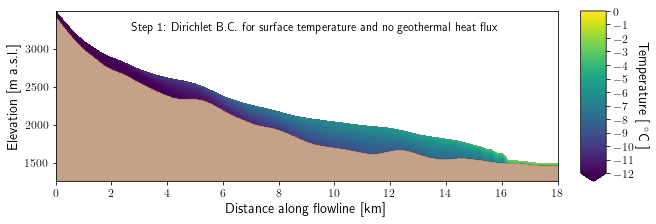

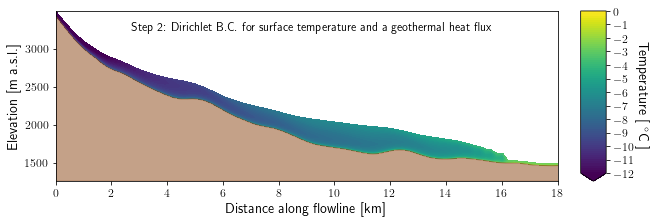

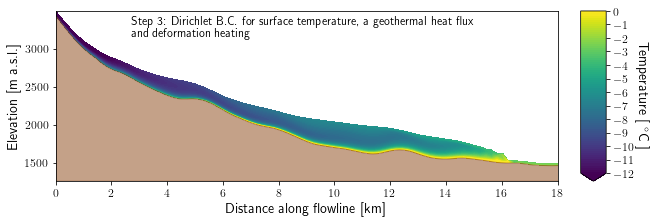

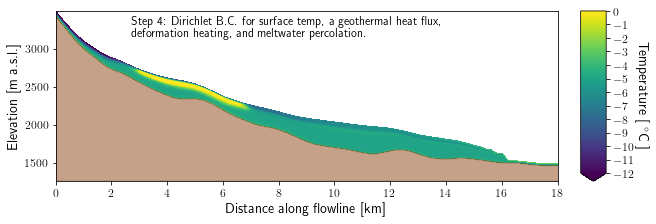

In [30]:
contourf_kwargs = {
    'cmap'   : 'viridis',
    'levels' : np.linspace(-12, 0.0, 81), 
    'extend' : 'min'
    }

def plot_temp(step, time, contourf_kwargs = {None : None}, label = None):
    fig, ax = plt.subplots(1,1, figsize=(9,3), 
                           constrained_layout=True)
    
    im = ax.contourf(heat_sources.sel(step=step).X[::-1,:] / 1e3, 
                 heat_sources.sel(step=step).Z.sel(t=time),
                 heat_sources.sel(step=step)['temperature'].sel(t=time),
                 **contourf_kwargs)

    cbar = fig.colorbar(im, 
                        ax = ax, 
                        ticks = np.linspace(-12, 0.0, 13), 
                       )

    cbar.set_label('Temperature [ $^{\circ}$C ]', rotation=270, labelpad=15)

    ax.text(0.15, 0.9, label,
            transform=ax.transAxes,
            ha='left', va='center')
    
    ax.set_xlim(None, 18)
    ax.set_ylim(bed[:,1].min(), None)

    ax.set_ylabel('Elevation [m a.s.l.]')
    ax.set_xlabel('Distance along flowline [km]')
    
    ax.fill_between(bed[::-1,0] / 1e3, bed[:,1].min()*np.ones_like(bed[:,1]), 
                bed[:,1]-5.0, color='saddlebrown', alpha=0.5)
    
    
    fig.savefig(f'./figs/heatsources_{step}.png',
            dpi = 400, bbox_inches='tight',
            facecolor='w')
    
times  = [22, 22, 100, 10]
labels = ['Step 1: Dirichlet B.C. for surface temperature and no geothermal heat flux',
          'Step 2: Dirichlet B.C. for surface temperature and a geothermal heat flux',
          'Step 3: Dirichlet B.C. for surface temperature, a geothermal heat flux\n\
          and deformation heating',
          'Step 4: Dirichlet B.C. for surface temp, a geothermal heat flux, \n\
          deformation heating, and meltwater percolation.'] 

bed  = np.loadtxt('../../input_data/lilk-a_bed.dat')
surf = np.loadtxt('../../input_data/lilk-a_surf.dat')

for i in np.arange(0, 4, dtype=np.int):
    step  = f"Step{i+1}"

    plot_temp(step, times[i], contourf_kwargs, labels[i])
    

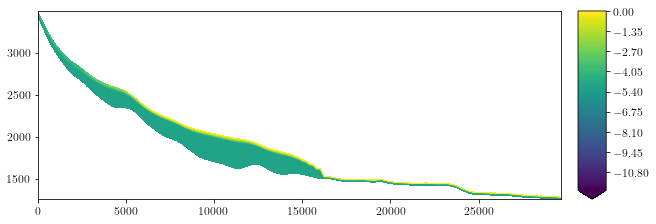

In [40]:
fig, ax = plt.subplots(1,1,figsize=(9,3), constrained_layout=True, 
                       sharex=True, sharey=True)


im = ax.contourf(heat_sources.sel(step='Step4').X[::-1,:], 
                 heat_sources.sel(step='Step4').Z.sel(t=10),
                 heat_sources.sel(step='Step4')["temperature"].isel(t=0),
                   **contourf_kwargs)
cbar = fig.colorbar(im, ax=ax)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(9,3), constrained_layout=True, 
                       sharex=True, sharey=True)


im = ax.contourf(heat_sources.sel(step='Step4').X[::-1,:], 
                 heat_sources.sel(step='Step4').Z.sel(t=10),
                 heat_sources.sel(step='Step4')["temperature"].sel(t=10) - \
                 levels = np.linspace(-10,10,41), extend='both',
                 cmap = 'RdBu_r')
cbar = fig.colorbar(im, ax=ax)

# Glacier Selection

In [10]:
# find all the input .dat files
dat_fps = glob.glob("../../input_data/*.dat")
# strip the key-id from the file path, only want unique values
keys = set(fp.split('/')[-1].split('_')[0] for fp in dat_fps)

# legend labels dictionary
labels = {'fish' : 'Fisher', 
          'glc1' : 'South' , 
          'klut' : 'Klutlan', 
          'sprg' : 'Spring',
          'lilk' : 'Little Kluane', 
          'klun' : 'Kluane', 
          'twds' : 'Tweedsmuir',
          'crmpt18' : 'Glacier 18',
          'crmpt12' : 'Glacier 12'}

# hex codes from colorbrewer
colors = ['#7fc97f','#beaed4','#fdc086','#ffff99',
          '#386cb0','#f0027f','#bf5b17','#666666', '#7fc97f']

color = plt.cm.tab20b(np.linspace(0, 1,10), 10)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color', color)
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for color in colors: 
    color[3] = 0.5

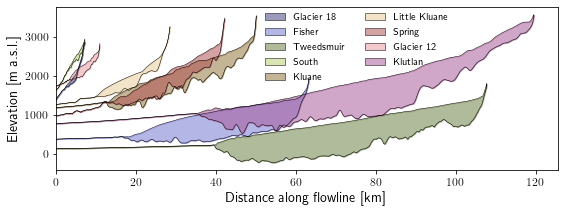

In [16]:
fig, ax = plt.subplots(figsize=(9,3))

i = 0 

legend_elements = [ ]


for key in keys:
    # skip the secondary flowlines for now
    if '-a' in key: continue
        
    surf_fp = '../../input_data/{}_surf.dat'.format(key)
    bed_fp  = '../../input_data/{}_bed.dat' .format(key)
    
    surf = np.loadtxt(surf_fp)
    bed  = np.loadtxt(bed_fp )
    
    x   = surf[:,0]
    z_s = surf[:,1]
    z_b =  bed[:,1]
    
    
    ax.plot(x/1e3, z_s, c='k', lw=0.5)
    ax.plot(x/1e3, z_b, c='k', lw=0.5)
    ax.fill_between(x/1e3, z_b, z_s, color=colors[i])
    
    legend_elements.append( Patch(facecolor=colors[i], edgecolor='k',
                                  linewidth = 0.5, 
                                  label=labels[key.split('-')[0]]))
    
    i += 1

# Place legend in the correct spot
ax.legend(handles = legend_elements, fontsize='small', ncol=2, 
          loc = 'upper center', framealpha=0.00, frameon=False, 
          bbox_to_anchor=(0.6, 1.025)
          )

ax.set_xlim(0, None)

ax.set_ylabel('Elevation [m a.s.l.]')
ax.set_xlabel('Distance along flowline [km]')

fig.savefig('./figs/all_glaciers.png', dpi=400, bbox_inches='tight', facecolor='w')